<a href="https://colab.research.google.com/github/anuartista/VocationMap/blob/master/Project_Rough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
 pip install classification_report

In [ ]:
 pip install emoji

In [ ]:
!pip3 install emoji
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", -1)
from time import time
import re
import string
import os
import emoji 
import sklearn
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style= "darkgrid")
sns.set(font_scale= 1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings 
warnings.filterwarnings('ignore')
np.random.seed()


# LoadData

In [ ]:
# for uploading the dataset from the sysytem

# import io
# from google.colab import filterwarnings

# train_tsv = files.upload()
# airlines_train = pd.read_csv(io.BytesIO(train_tsv["Tweets.csv"]))



In [ ]:
airlines_train = pd.read_csv("/content/drive/MyDrive/MSc_AI/internship/data/Tweets.csv")

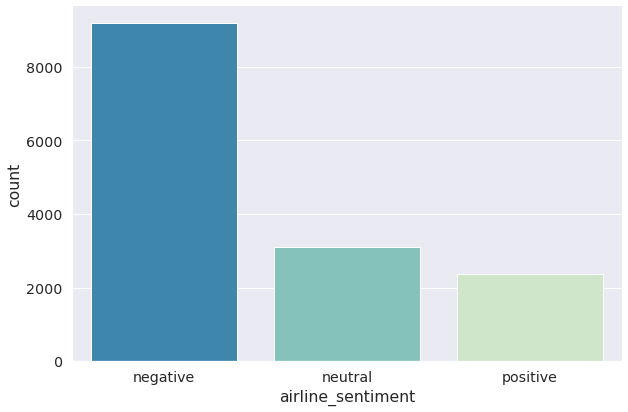

In [ ]:
airlines_train = airlines_train.reindex(np.random.permutation(airlines_train.index))
airlines_train = airlines_train[["text", "airline_sentiment"]]

sns.factorplot(x ="airline_sentiment", data = airlines_train, kind= "count", size= 6, aspect= 1.5, palette= "GnBu_r")
plt.show();

# TextClean

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
      return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
      return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

    def emoji_oneword(self, input_text):
      # By compressing the underscore, the emoji is kept as one word
      return input_text.replace('_','')

    def remove_punctuation(self, input_text):
      # Make translation table
      punct = string.punctuation
      trantab = str.maketrans(punct, len(punct)*' ') # Every punctuation symbol will be repalced by a space
      return input_text.translate(trantab)
    
    def remove_digits(self, input_text):
      return re.sub('\d+', '', input_text)

    def to_lower(self, input_text):
      return input_text.lower()

    def remove_stopwords(self, input_text):
      stopwords_list = stopwords.words('english')
      # Some words which might indicate a certain sentiment are kept via a whitelist
      whitelist = ["n't", "not", "no"]
      words = input_text.split()
      clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
      return " ".join(clean_words)

    def stemming(self, input_text):
      porter = PorterStemmer()
      words = input_text.split()
      stemmed_words = [porter.stem(word) for word in words]
      return " ".join(stemmed_words)

    def fit(self, X, y= None, **fit_params):
      return self

    def transform(self, X, **transform_params):
      clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits)
      return clean_X

# Use_CleanText

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
ct = CleanText()
sr_clean = ct.fit_transform(airlines_train.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
0 records have no words left after text cleaning


# CountVectorize_MostCommonWords

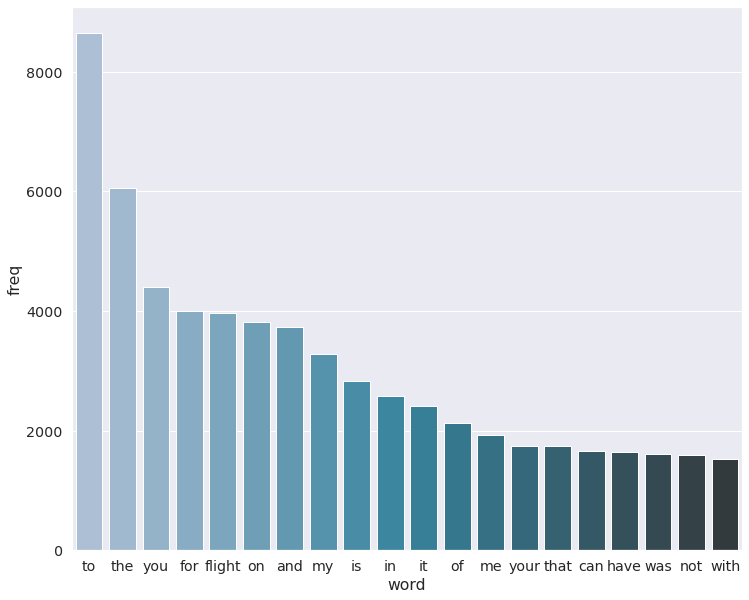

In [ ]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis = 0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fiq, ax = plt.subplots(figsize = (12, 10))
sns.barplot(x = "word", y = "freq", data = word_counter_df, palette = "PuBuGn_d", ax=ax)
plt.show();

# Grid Search

In [ ]:
# Based on https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text= None, vect= None, is_w2v = False):

  textcountscols = ['count_capital_words', 'count_emojis', 'count_excl_quest_marks', 'count_hashtags'
                    , 'count_mentions', 'count_urls', 'count_words']

  if is_w2v:
      w2vcols = []
      for i in range(SIZE):
          w2vcols.append(i)
      features = FeatureUnion([('textcounts', ColumnExtractor(cols = textcountscols))
                             , ('w2v', ColumnExtractor(cols=w2vcols))]
                            , n_jobs = -1)
  else:
      features = FeatureUnion([('textcounts', ColumnExtractor(cols = textcountscols))
                             , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols= 'clean_text')), ('vect', vect)]))]
                            , n_jobs= -1)
  pipeline= Pipeline([
      ('features', features)
      , ('clf', clf)
  ])


  # Join the parameters dictionaries together
  parameters = dict()
  if parameters_text:
       parameters.update(parameters_text)
  parameters.update(parameters_clf)          # make sure you have scikit-learn versiom 0.19 or higher to use multiple scoring matrics
  grid_search = GridSearchCV(pipeline, parameters, n_jobs= -1, verbose= 1, cv= 5)
  
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  pprint(parameters)
  t0 = time()
  grid_search.fit(X_train, y_train)
  print("done in %0.3fs" % (time() - t0))
  print()
  print("Best CV score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))

  print("Text score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
  print("\n")
  print("Classification Report Test Data")
  print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

  return grid_search

# Parameter Grid Search For Vectorizers

In [ ]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinominalNB
parameters_mnb = {
    'clf__alpha': (0.25,0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Column Extractor

In [ ]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
  def __init__(self, cols):
    self.cols = cols 
  def transform(self, X, **transform_params):
    return X[self.cols]
  def fit(self, X, y= None, **fit_params):
    return self

# Text Counts

In [ ]:
class TextCounts(BaseEstimator, TransformerMixin):

  def count_regex(self, pattern, tweet):
    return len(re.findall(pattern, tweet))

  def fit(self, X, y=None, **fit_params):
    # fit method is used when specific operations need to be done on the test data
    return self
  
  def transform(self, X, **transform_params):
    count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
    count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
    count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
    count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
    count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
    count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
    # We will replace the emoji symbols with a descrpition, which makes using a regex for counting easier
    # Moreover, it will result in having more words in the tweet
    count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))

    df = pd.DataFrame({'count_words': count_words
                       , 'count_mentions': count_mentions
                       , 'count_hashtags': count_hashtags
                       , 'count_capital_words': count_capital_words
                       , 'count_excl_quest_marks': count_excl_quest_marks
                       , 'count_urls': count_urls
                       , 'count_emojis': count_emojis
                       })
    
  
    return df
tc = TextCounts()
airlines_eda = tc.fit_transform(airlines_train.text)
airlines_eda['airline_sentiment'] = airlines_train.airline_sentiment



# Count Vectorizer Classifiers

In [ ]:
df_model = airlines_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('airline_sentiment', axis=1), df_model.airline_sentiment, test_size= 0.1, random_state= 37)
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer() # MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text= parameters_vect, vect= countvect)
# joblib.dump(best_mnb_countvect, '../output/best_mnb_countvect.pk1') # LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text = parameters_vect, vect= countvect)
# joblib.dump(best_logreg_countvect, '../output/best_logreg_countvect.pk1')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 86.307s

Best CV score: 0.794
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Text score with best_estimator_: 0.800


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88       910
     neutral       0.72      0.53      0.61       320
    positive       0.76      0.65      0.70       234

    accuracy                           0.80      1464
   macro avg       0.77      0.71      0.73      1464
weighted avg       0.79      0.80      0.79      1464

Performing grid search...
pipeline: ['feature

# TFIDF_Classifers

In [ ]:
tfidfvect = TfidfVectorizer() # MultinominalNB
print("MultinomialNB")
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text= parameters_vect, vect= tfidfvect)
# LogisticRegression
print("LogisticRegression")
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

MultinomialNB
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 84.198s

Best CV score: 0.751
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Text score with best_estimator_: 0.745


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.98      0.84       910
     neutral       0.75      0.32      0.44       320
    positive       0.79      0.42      0.55       234

    accuracy                           0.74      1464
   macro avg       0.76      0.57      0.61      1464
weighted avg       0.75      0.74      0.71      1464

LogisticRegression
Performing 